## Adversarial model
- ML은 유용하지만, 보안적 취약성이 아직 두드러진다.
  - 약간의 노이즈로 전혀다른 결과가 나올 수 있다.
  - 이러한 작은 변화들을 perturbation(눈으로는 문제없는 정도의 변화) 라고 부르며
      - 이러한 변화를 생성하는 대표적인 방법으로 Fast Gradient Sign Method (FGSM) 이라는 이안 굿 펠로우의 기법이 있다.
      - 이번 예제는 이런 FGSM을 해볼거다.
  
> Fast Gradient Sign Method (FGSM) 요거는 [Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572)(2014)


- Adversarial example(위협 모델)
  - 공격 유형에 따라 잘못 분류하게하는 perturbation을 크게 화이트박스/블랙박스 공격방식이 있다.
    - 화이트박스 : 모델에 대해 아키텍쳐, 입력, 출력, 가중치를 포함한 모든 것을알고 있는 공격
    - 블랙박스 공격 : 입력과 출력에 대해서만 접근이 가능한 공격
  - 오류 유형 목표에 따른 분류
    - 오분류 : 그냥 틀리게만 하면됨
    - 소스/타겟 : 특정 타겟으로 오분류하게함
  - FGSM은 오분류를 목표로하는 화이트박스 task


In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# NOTE: 아래는 MNIST 데이터셋을 내려받을 때 "User-agent" 관련한 제한을 푸는 코드입니다.
#       더 자세한 내용은 https://github.com/pytorch/vision/issues/3497 을 참고해주세요.
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [2]:
epsilons = [0, .05, .1, .15, .2, .25, .3] # 0은 원래 테스트셋의 모델 성능, 1보다는 작아야함, 당연히 작게 바꿔서 틀리게하면 더 대단한것
pretrained_model = "/raid/jskim/data/pretrained/lenet_mnist_model.pth" # pretrained model path
use_cuda=True

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# MNIST 테스트 데이터셋과 데이터로더 선언
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/raid/jskim/data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

# 어떤 디바이스를 사용할지 정의
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# 모델 초기화하기
model = Net().to(device)

# 미리 학습된 모델 읽어오기
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# 모델을 평가 모드로 설정하기. 드롭아웃 레이어들을 위해 사용됨
model.eval()


Extracting /raid/jskim/data/MNIST/raw/train-images-idx3-ubyte.gz to /raid/jskim/data/MNIST/raw




Extracting /raid/jskim/data/MNIST/raw/train-labels-idx1-ubyte.gz to /raid/jskim/data/MNIST/raw




Extracting /raid/jskim/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /raid/jskim/data/MNIST/raw




Extracting /raid/jskim/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /raid/jskim/data/MNIST/raw

CUDA Available:  True


/opt/conda/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:174.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [23]:
# FGSM 공격 코드
def fgsm_attack(image, epsilon, data_grad):
    # data_grad 의 요소별 부호 값을 얻어옵니다 저 data grad값은 model에서 loss.backward를 통해서 생긴 grad
    sign_data_grad = data_grad.sign()
    # 입력 이미지의 각 픽셀에 sign_data_grad 를 적용해 작은 변화가 적용된 이미지를 생성합니다
    perturbed_image = image + epsilon*sign_data_grad
    # 값 범위를 [0,1]로 유지하기 위해 자르기(clipping)를 추가합니다
    perturbed_image = torch.clamp(perturbed_image, 0, 1) # min = 0, max = 1로 입력되었음, 0보다작으면 다 0 & 1보다 크면 다 1
    # 작은 변화가 적용된 이미지를 리턴합니다
    return perturbed_image

In [30]:
def test( model, device, test_loader, epsilon ):

    # 정확도 카운터
    correct = 0
    adv_examples = []

    # 테스트 셋의 모든 예제에 대해 루프를 돕니다
    for data, target in test_loader:

        # 디바이스(CPU or GPU) 에 데이터와 라벨 값을 보냅니다
        data, target = data.to(device), target.to(device)

        # 텐서의 속성 중 requires_grad 를 설정합니다. 공격에서 중요한 부분입니다 -> 이 그라드가 입력으로 들어갈것이오
        data.requires_grad = True

        # 데이터를 모델에 통과시킵니다
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # 로그 확률의 최대값을 가지는 인덱스를 얻습니다

        # 만약 초기 예측이 틀리면, 공격하지 않도록 하고 계속 진행합니다
        if init_pred.item() != target.item():
            continue

        # 손실을 계산합니다
        loss = F.nll_loss(output, target)

        # 모델의 변화도들을 전부 0으로 설정합니다
        model.zero_grad()

        # 후방 전달을 통해 모델의 변화도를 계산합니다
        loss.backward()

        # 변화도 값을 모읍니다
        
        data_grad = data.grad.data # data.grad에는 tensor가 있어서 data를 해줘야 값이 나옴

        # FGSM 공격을 호출합니다
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # 작은 변화가 적용된 이미지에 대해 재분류합니다
        output = model(perturbed_data)

        # 올바른지 확인합니다
        final_pred = output.max(1, keepdim=True)[1] # 로그 확률의 최대값을 가지는 인덱스를 얻습니다
        if final_pred.item() == target.item():
            correct += 1
            # 0 엡실론 예제에 대해서 저장합니다
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # 추후 시각화를 위하 다른 예제들을 저장합니다
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        break

    # 해당 엡실론에서의 최종 정확도를 계산합니다
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # 정확도와 적대적 예제를 리턴합니다
    return final_acc, adv_examples

In [31]:
accuracies = []
examples = []

# 각 엡실론에 대해 테스트 함수를 실행합니다
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

tensor([[[[-6.9716e-06,  3.8252e-05, -3.4481e-05, -5.5064e-05,  3.3772e-05,
            7.0777e-06,  3.7002e-05, -1.5885e-04, -6.6084e-05,  4.4044e-05,
            2.2013e-04,  1.2218e-04,  1.6790e-04, -7.2229e-05, -1.8092e-04,
           -1.4405e-04, -1.3624e-04,  1.9108e-04,  2.8650e-04,  1.5840e-04,
            1.9803e-04, -1.3667e-04, -3.4599e-04, -4.6655e-04, -6.6708e-04,
           -2.4262e-04, -3.4418e-04, -1.4370e-10],
          [ 4.1262e-05, -5.5724e-05, -6.6786e-05, -1.3754e-04, -8.5892e-05,
           -4.2071e-05, -2.3640e-05,  1.0822e-04, -3.4659e-05,  2.1473e-04,
           -1.1165e-04,  1.1038e-04,  2.0096e-04,  1.1623e-04, -2.1835e-05,
            2.1514e-04,  3.6285e-04,  5.5764e-05, -7.8397e-04, -3.3270e-04,
            7.5494e-05,  2.9569e-04,  1.6289e-04, -1.9034e-04, -3.5081e-04,
           -3.0584e-04, -4.7541e-04, -1.7280e-10],
          [ 3.1374e-04, -5.0602e-06,  4.7143e-05, -3.3990e-04, -3.7849e-04,
           -5.3265e-04, -7.5527e-05,  1.4965e-04,  8.5150e-05,

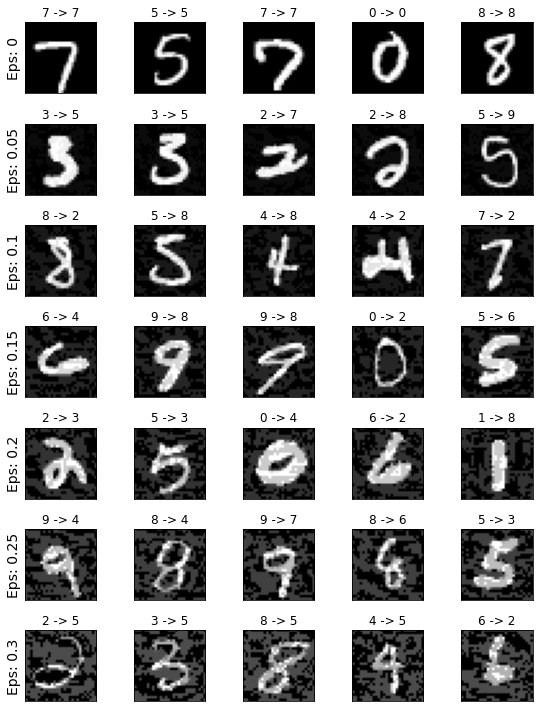

In [13]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()